# Afriat

In [1]:
ood_seed = 10

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('0', 'Pericentral', 'Control')

Removed datapoint: 546


train         14830
validation     3677
ood             546
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19053/19053 [00:00<00:00, 669280.29it/s]
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 363.83it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-d7a14d27-a4ce-50f4-ac0d-9574c956ed5a]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/1: 100%|██████████████████████████████████████████| 1/1 [00:23<00:00, 23.82s/it, v_num=1, recon=3.99e+3, r2_mean=0.202, adv_loss=3.32, acc_pert=0.228, acc_zone=0.751, acc_status_control=0.499]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 1/1: 100%|██████████████████████████████████████████| 1/1 [00:23<00:00, 23.85s/it, v_num=1, recon=3.99e+3, r2_mean=0.202, adv_loss=3.32, acc_pert=0.228, acc_zone=0.751, acc_status_control=0.499]


In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 596/596 [00:02<00:00, 290.60it/s]


In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

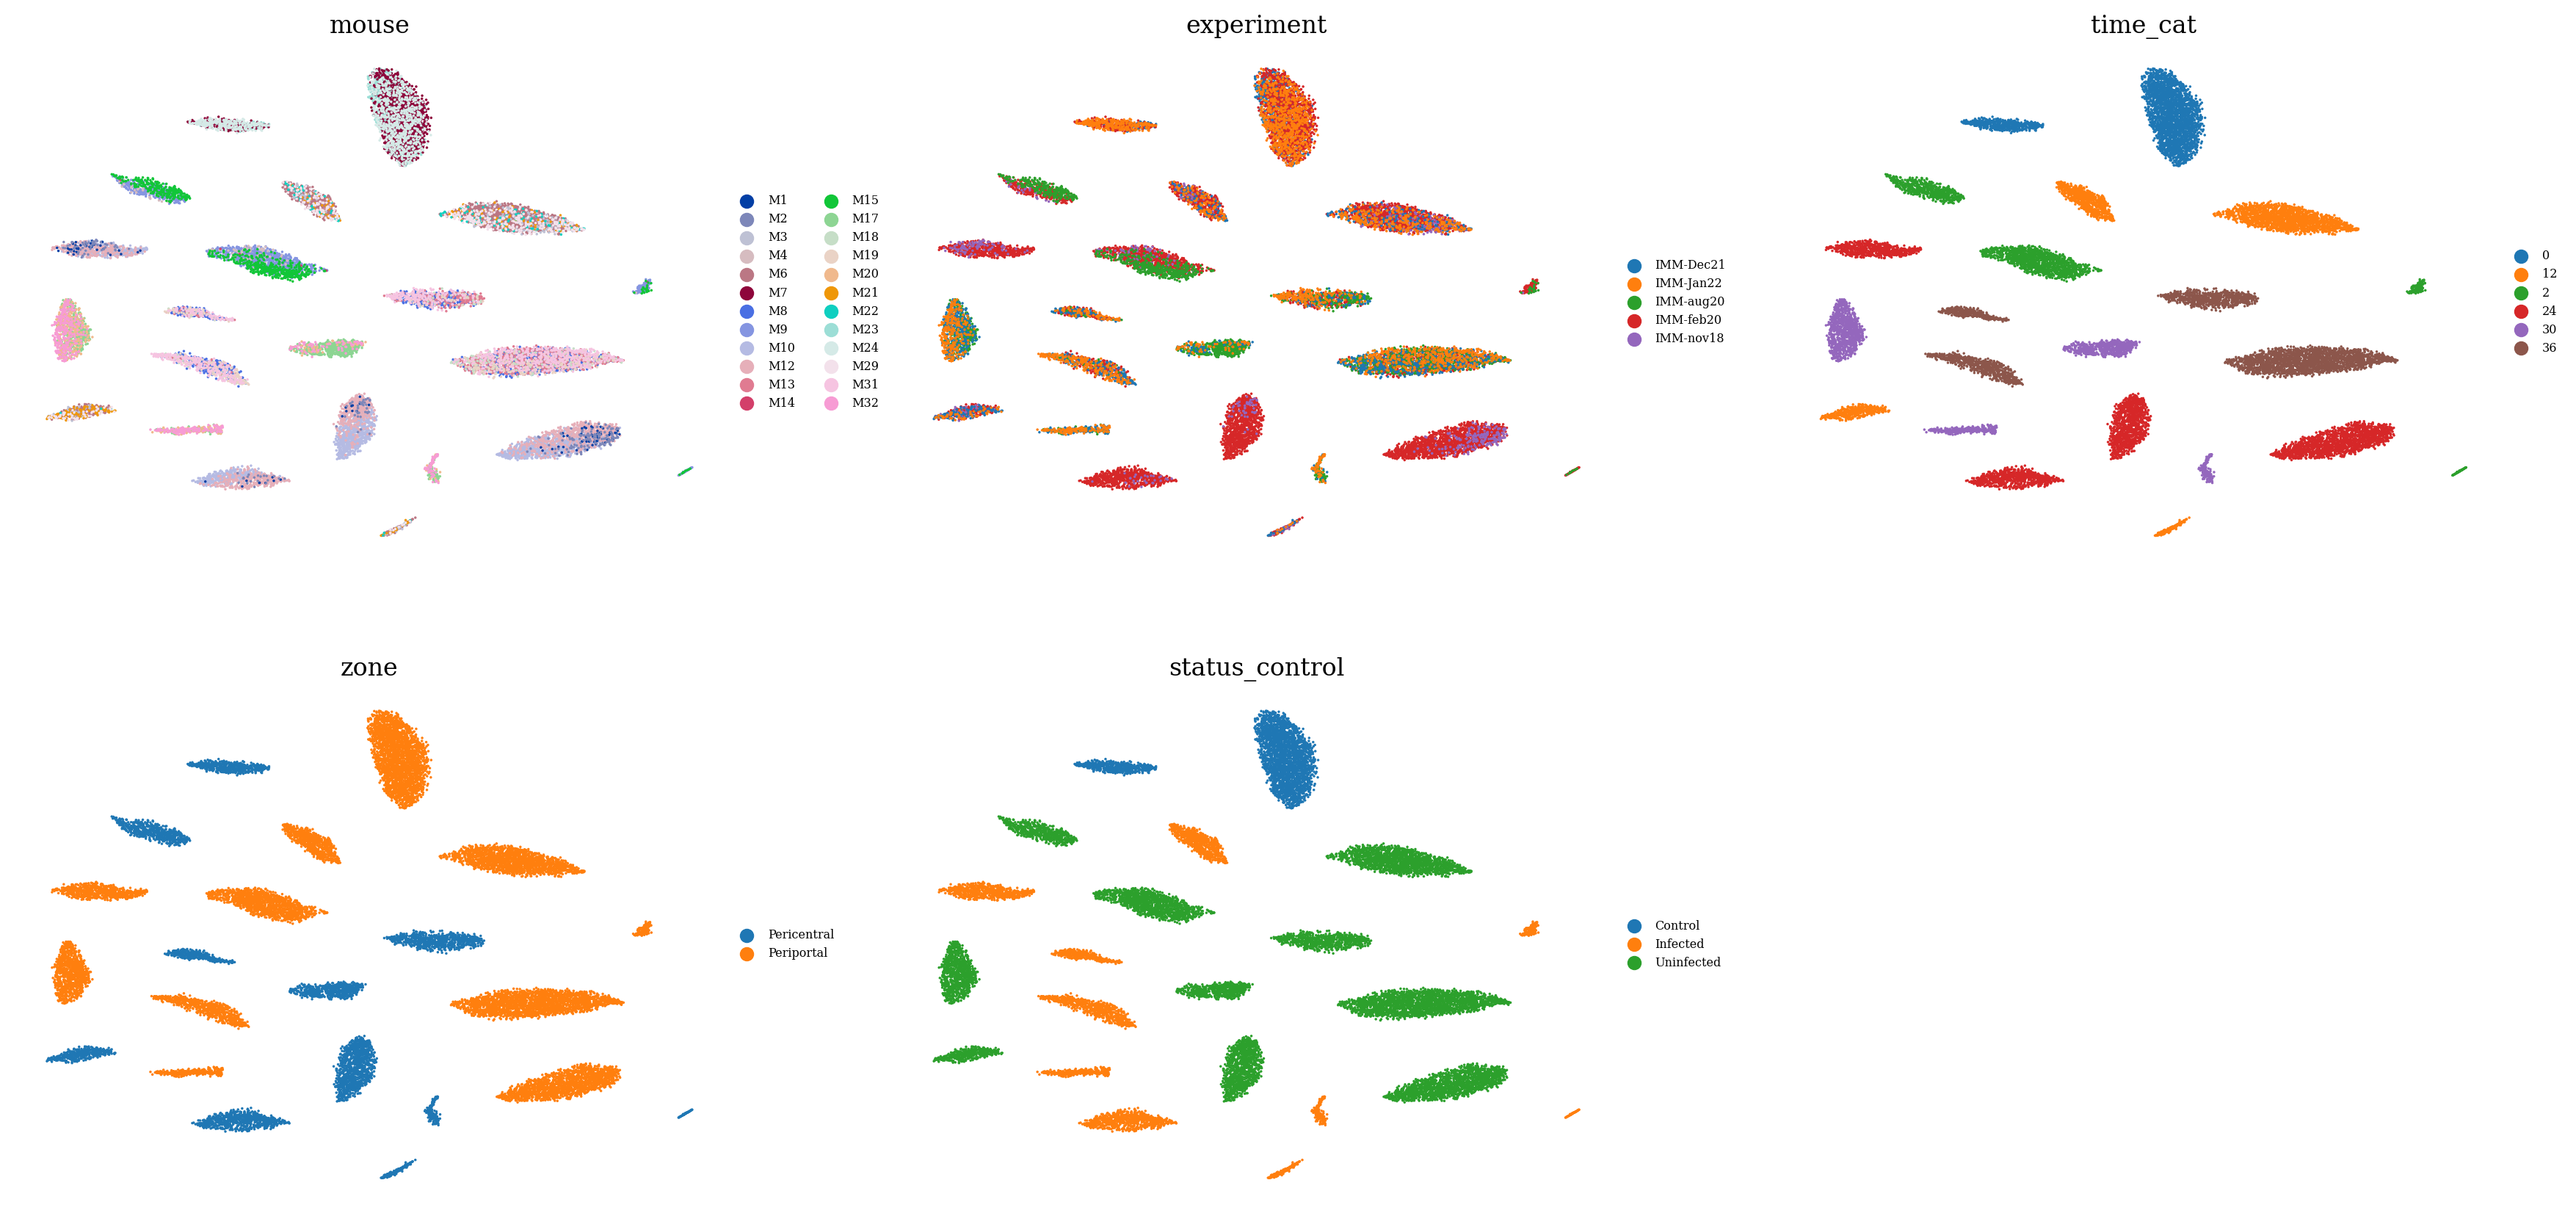

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

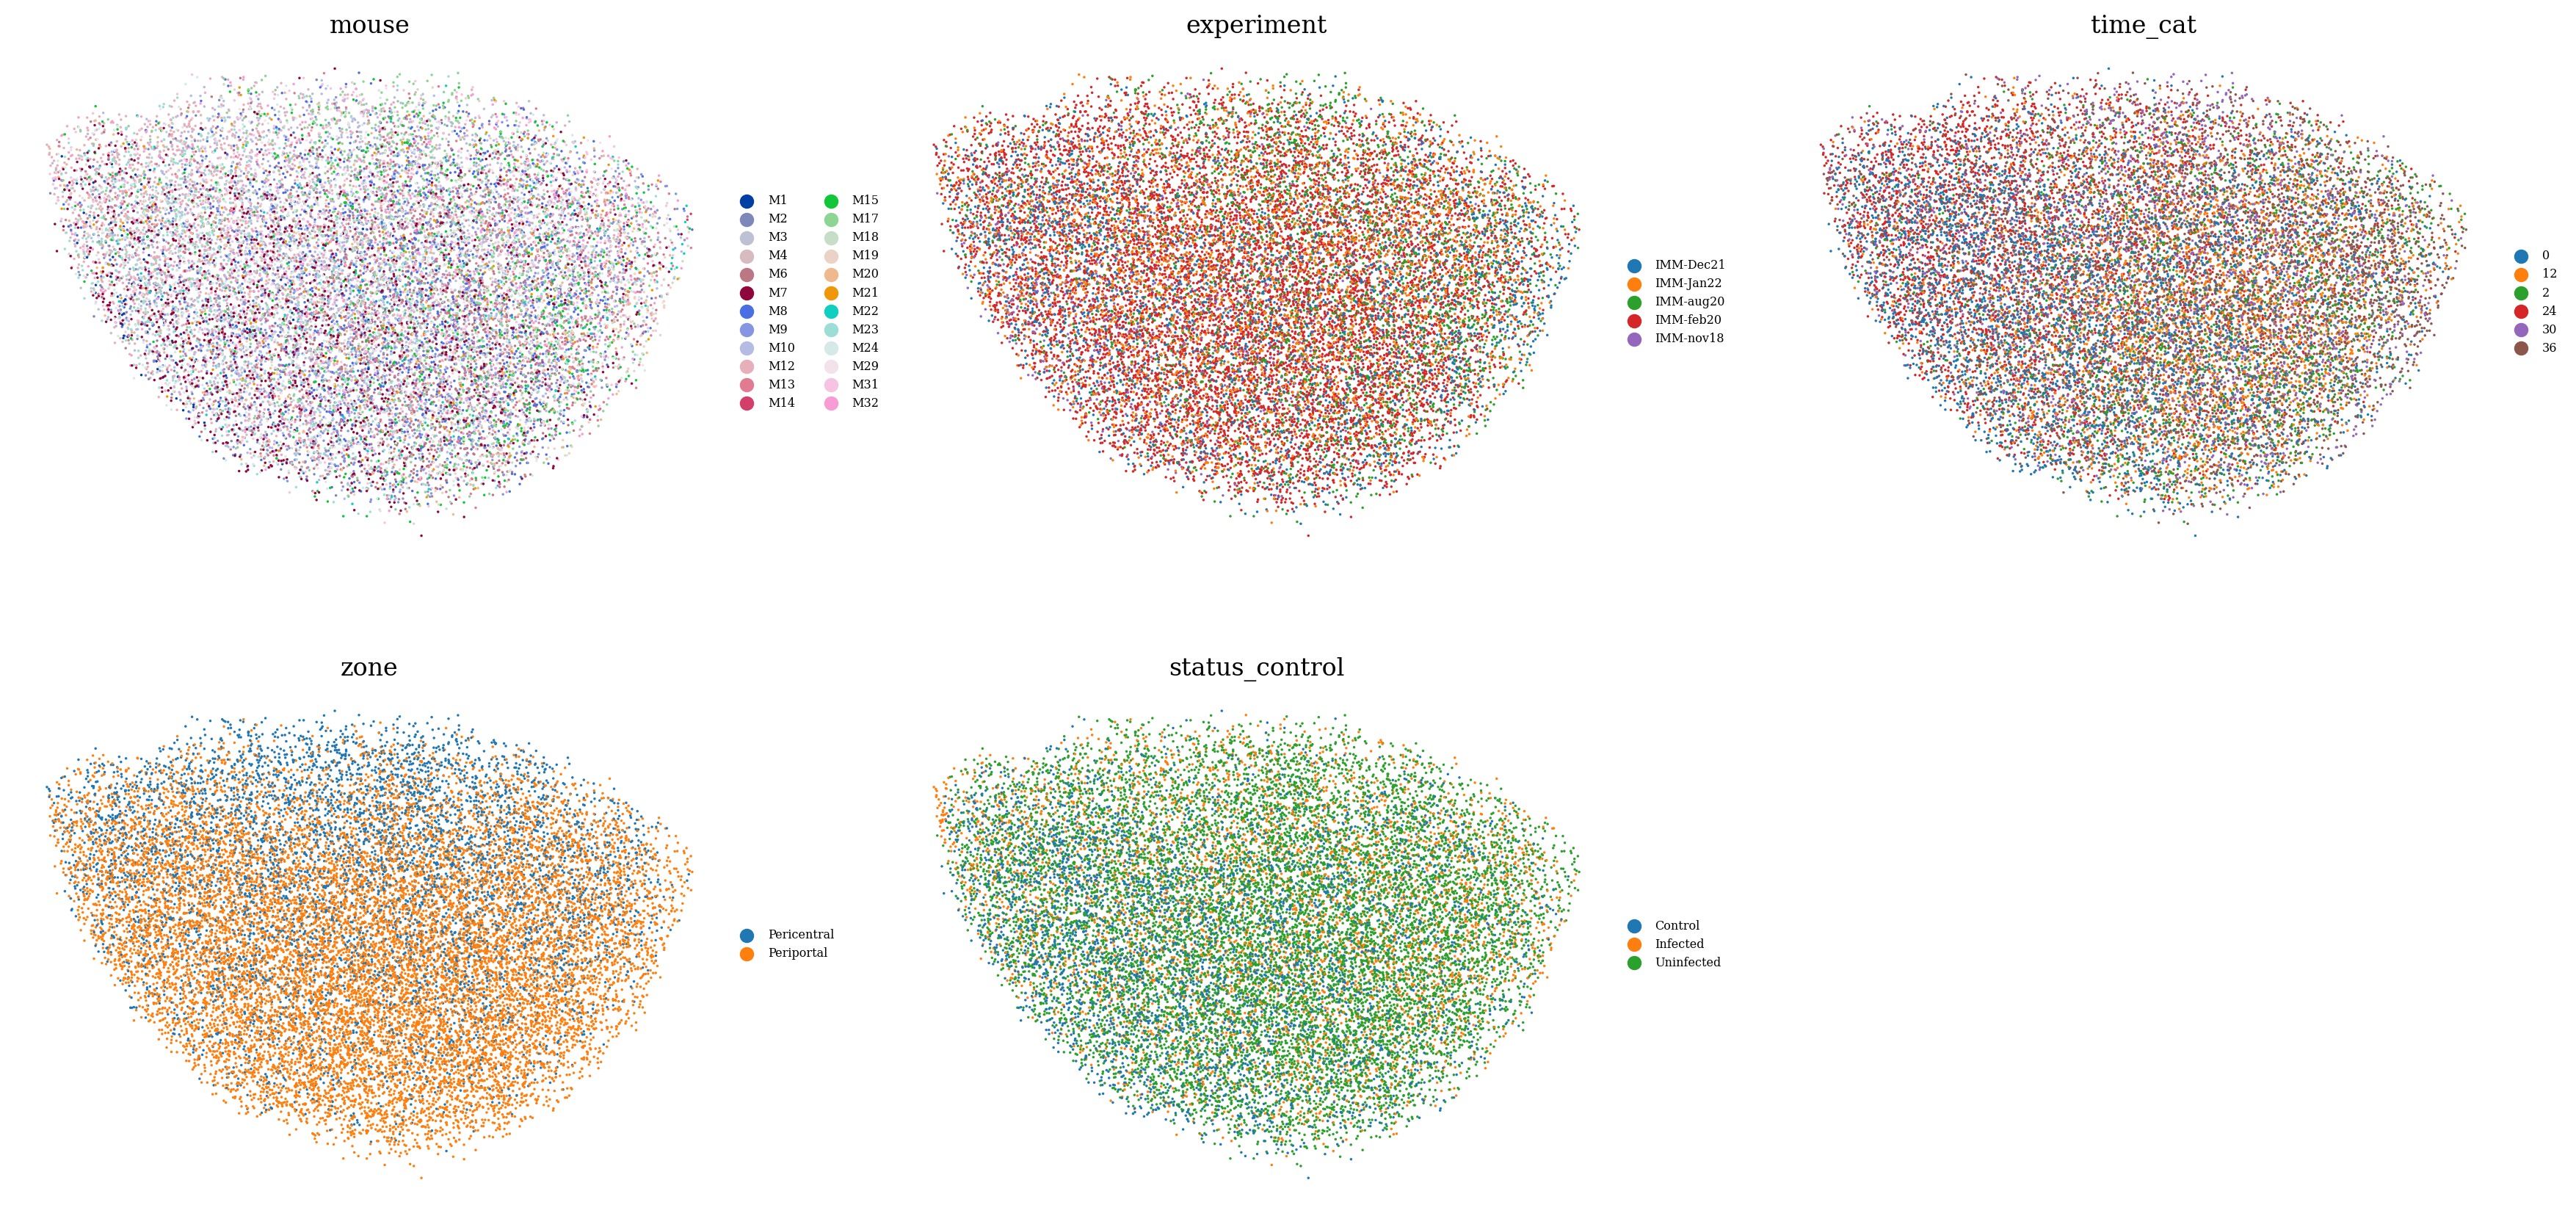

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 596/596 [00:02<00:00, 262.75it/s]


In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0 32
32 64
64 96
96 128
128 160
160 192
192 224
224 256
256 288
288 320
320 352
352 384
384 416
416 448
448 480
480 512
512 544


In [23]:
np.mean(r2s)

-9.625168714908744e-05

In [ ]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)